In [29]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import copy
from sklearn.model_selection import train_test_split
from torchsummary import summary


# for importing data
import torchvision

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")

<ipython-input-29-f13b161a60e1>:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")


In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpue")

# Import and inspect the data

In [31]:
letter_data = torchvision.datasets.EMNIST(root="emnist",split="letters",download=True)
digit_data = torchvision.datasets.EMNIST(root="emnist", split="digits", download=True)

In [32]:
print(letter_data.classes)
print(str(len(letter_data.classes)) + ' classes')

print('\nData size:')
print(letter_data.data.shape)

# transform to 4D tensor for conv layers (and transform from int8 to float)
images = letter_data.data.view([124800,1,28,28]).float()
print('\nTensor data:')
print(images.shape)


['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27 classes

Data size:
torch.Size([124800, 28, 28])

Tensor data:
torch.Size([124800, 1, 28, 28])


In [33]:
imSize = int(images.shape[2])

In [34]:
# brief: class 'N/A' doesn't exist in the data.
print( torch.sum(letter_data.targets==0) )

# However, it causes problems in one-hot encoding...
torch.unique(letter_data.targets)

tensor(0)


tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26])

In [35]:
letter_data.class_to_idx

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [36]:
# so therefore we'll eliminate it and subtract 1 from the original

# remove the first class category
letterCategories = letter_data.classes[1:]

# relabel labels to start at 0
labels = copy.deepcopy(letter_data.targets)-1
print(labels.shape)

###
print( torch.sum(labels==0) )
torch.unique(labels)

torch.Size([124800])
tensor(4800)


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])

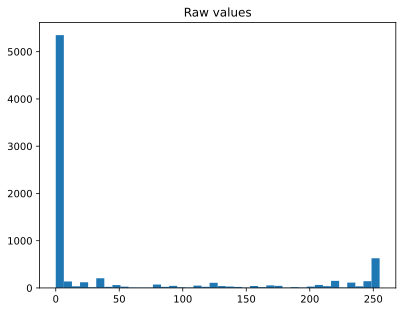

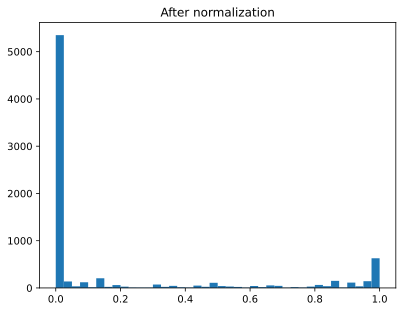

In [37]:
# next issue: do we need to normalize the images?
plt.hist(images[:10,:,:,:].view(1,-1).detach(),40);
plt.title('Raw values')
plt.show()

# yeap.
images /= torch.max(images)

plt.hist(images[:10,:,:,:].view(1,-1).detach(),40);
plt.title('After normalization')
plt.show()

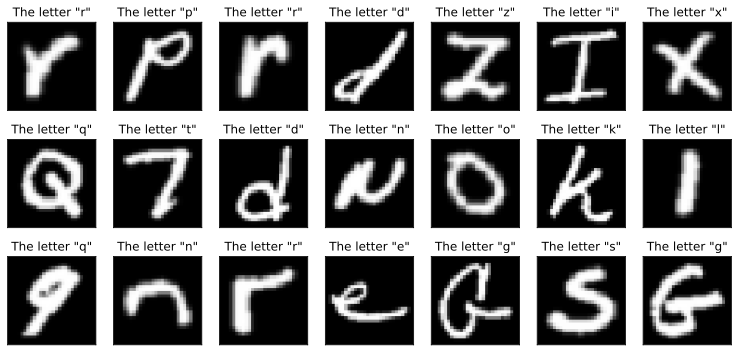

In [38]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):

  # pick a random pic
  whichpic = np.random.randint(images.shape[0])

  # extract the image and its target letter
  I = np.squeeze( images[whichpic,:,:] )
  letter = letterCategories[labels[whichpic]]

  # visualize
  ax.imshow(I.T,cmap='gray')
  ax.set_title('The letter "%s"'%letter)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Create train/test groups using DataLoader

In [39]:
# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
letter_train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
letter_test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [40]:
# check size (should be images X channels X width X height
print( letter_train_loader.dataset.tensors[0].shape )
print( letter_train_loader.dataset.tensors[1].shape )

torch.Size([112320, 1, 28, 28])
torch.Size([112320])


# Create the DL model

In [41]:
a = nn.Conv2d(1, 6, 3, padding=1)
k = (imSize + 2 * int(a.padding[1]) - a.kernel_size[1]) / a.stride[1] + 1
k

28.0

In [42]:
def makeTheNet(printtoggle=False):

  class emnistnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      self.dropout = nn.Dropout(0.2)
      # print toggle
      self.print = printtoggle

      # first convolution layer
      self.conv1  = nn.Conv2d(1,16,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(16) # input the number of channels in this layer
      # output size: (28+2*1-3)/1 + 1 = 28/2 = 14 (/2 b/c maxpool)
      hSize, wSize = self.calcSizes(self.conv1, hSize=imSize, wSize=imSize)

      # second convolution layer
      self.conv2  = nn.Conv2d(16,32,3,padding=1)
      self.bnorm2 = nn.BatchNorm2d(32) # input the number of channels in this layer
      # output size: (14+2*1-3)/1 + 1 = 14/2 = 7 (/2 b/c maxpool)
      hSize, wSize = self.calcSizes(self.conv2, hSize=hSize, wSize=wSize)
      # Linear Layers

      nUnits = hSize * wSize * self.conv2.out_channels
      self.fc1 = nn.Linear(nUnits ,50)
      self.fc2 = nn.Linear(50,26)

      self.to(device)

    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      x = self.dropout(x)
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      x = self.dropout(x)
      if self.print: print(f'Second CPR block: {list(x.shape)}')
      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorized: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = self.fc2(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

    def calcSizes(self, convLayer: nn.Conv2d, hSize: int, wSize: int):
      hSize = ((np.floor((hSize + 2 * int(convLayer.padding[0]) - convLayer.kernel_size[0]) / convLayer.stride[0] + 1)) / 2).astype(int)
      wSize = ((np.floor((wSize + 2 * int(convLayer.padding[1]) - convLayer.kernel_size[1]) / convLayer.stride[1] + 1)) / 2).astype(int)
      return hSize, wSize

  # create the model instance
  net = emnistnet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [43]:
rImgs = torch.randn((120, 1, 28, 28)).to(device)
net,lossfun,optimizer = makeTheNet(True)
net(rImgs)


Input: [120, 1, 28, 28]
First CPR block: [120, 16, 14, 14]
Second CPR block: [120, 32, 7, 7]
Vectorized: [120, 1568]
Final output: [120, 26]


tensor([[ 0.2302,  0.2604, -0.1031,  ...,  0.2251,  0.0167, -0.2845],
        [-0.0933,  0.0686, -0.0968,  ..., -0.0894,  0.0883, -0.3755],
        [-0.1587,  0.1251, -0.1065,  ..., -0.1127,  0.1280, -0.3003],
        ...,
        [-0.1098,  0.2690, -0.3084,  ..., -0.0253,  0.1514, -0.2363],
        [ 0.0116,  0.2676, -0.0203,  ..., -0.0727,  0.0805, -0.0395],
        [-0.0382,  0.3249, -0.3166,  ..., -0.1582,  0.1723, -0.1639]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [44]:
summary(net, (1, imSize, imSize))

Input: [2, 1, 28, 28]
First CPR block: [2, 16, 14, 14]
Second CPR block: [2, 32, 7, 7]
Vectorized: [2, 1568]
Final output: [2, 26]
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 14, 14]              32
           Dropout-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
       BatchNorm2d-5             [-1, 32, 7, 7]              64
           Dropout-6             [-1, 32, 7, 7]               0
            Linear-7                   [-1, 50]          78,450
            Linear-8                   [-1, 26]           1,326
Total params: 84,672
Trainable params: 84,672
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.22
Params size (MB): 0.32
Estimated 

In [45]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet(True)

X,y = next(iter(letter_train_loader))
X = X.to(device)
y = y.to(device)
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)

Input: [32, 1, 28, 28]
First CPR block: [32, 16, 14, 14]
Second CPR block: [32, 32, 7, 7]
Vectorized: [32, 1568]
Final output: [32, 26]

Output size:
torch.Size([32, 26])
 
Loss:
tensor(3.2737, device='cuda:0', grad_fn=<NllLossBackward0>)


# Create a function that trains the model

In [46]:
# a function that trains the model

def function2trainTheModel(net,lossfun,optimizer, train_loader, test_loader, numepochs=10):

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainErr  = torch.zeros(numepochs)
  testErr   = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
    batchErr  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchErr.append( torch.mean((torch.argmax(yHat,axis=1) != y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainErr[epochi]  = 100*np.mean(batchErr)



    ### test performance
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # get loss and error rate from the test batch
    testLoss[epochi] = loss.item()
    testErr[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) != y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainErr,testErr,net

# Run the model and show the results!

In [47]:
# ~2 minutes with 10 epochs on GPU (8 mins on the CPU!)
net, lossfun, optimizer = makeTheNet()
trainLoss,testLoss,trainErr,testErr,net = function2trainTheModel(net, lossfun, optimizer, letter_train_loader, letter_test_loader, 5)

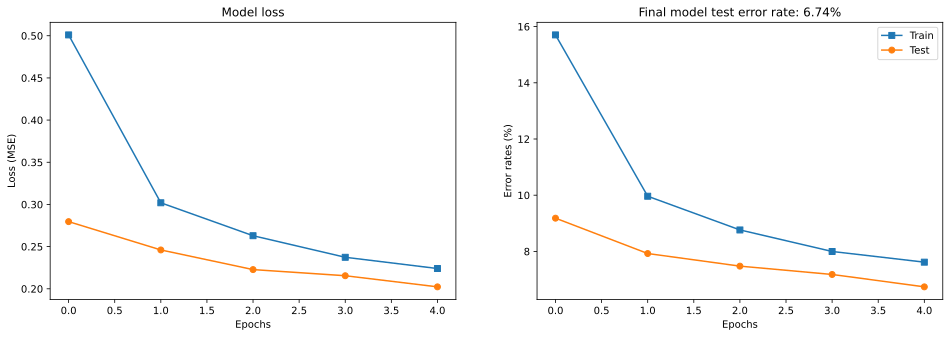

In [48]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(testErr,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr[-1]:.2f}%')
ax[1].legend()

plt.show()

# Transfer Learning

* Applying Transfer Learning by using pretreained letters EMNIST dataset.
* Use digits to test this dataset.

In [50]:
digit_data.data.shape

torch.Size([240000, 28, 28])

* We have 240 thousands of images of digits.


In [55]:
digit_imgs = digit_data.data.view([digit_data.data.shape[0], 1, 28, 28]).float()
digit_imgs.shape

torch.Size([240000, 1, 28, 28])

In [59]:
digit_imgs /= torch.max(digit_imgs)

# split the images and convert to dataloaders
train_data, test_data, train_labels,test_labels = train_test_split(digit_imgs, digit_data.targets, test_size=.1)

# convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# translate into dataloader objects
batchsize = 32
digit_train_loader = DataLoader(train_data, batch_size=batchsize,shuffle=True, drop_last=True)
digit_test_loader  = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [63]:
digitClasses = digit_data.classes


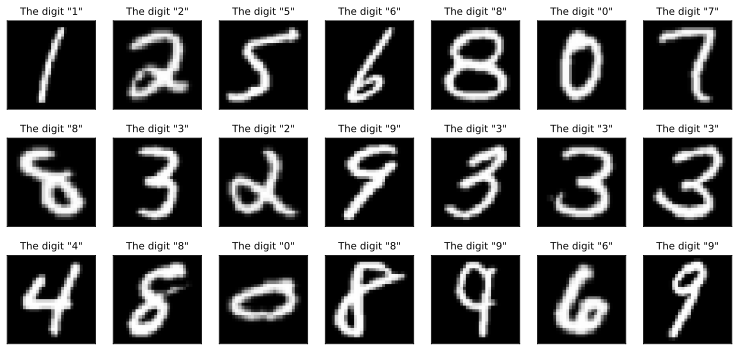

In [65]:
# visualize some letters
fig,axs = plt.subplots(3,7,figsize=(13,6))

# get a batch of letter data
X,y = next(iter(digit_train_loader))

for i,ax in enumerate(axs.flatten()):

  # extract the image and its target letter
  I = np.squeeze( X[i,:,:] )
  digit = digitClasses[y[i]]

  # visualize
  ax.imshow(I.T,cmap="gray",vmin=0,vmax=1)
  ax.set_title('The digit "%s"'%digit,fontsize=10)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [69]:
X, y = next(iter(digit_test_loader))

X = X.to(device)
y = y.to(device)

net.eval()
yHat = net(X)
numberErr = 100 * torch.mean((torch.argmax(yHat, axis=1) != y).float())
numberErr

tensor(96.2333, device='cuda:0')

* This result shows us the importance of fine tunning the model.
* In that experiment, we did not fine tuned model. It was just using the random parameters so that our result came in such a terrible.

## Fine Tunning the Model

* We first copy the parameters by trained letters.
* Then, change the output linear function, since we have 10 category labels ***0-10***.

In [72]:
digitNet, lossfun, optimizer = makeTheNet()

for target, source in zip(digitNet.named_parameters(), net.named_parameters()):
    target[1].data = copy.deepcopy(source[1].data) # Since, its not just copy it all, we should iterate and copy & paste it.

In [73]:
digitNet

emnistnet(
  (dropout): Dropout(p=0.2, inplace=False)
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1568, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=26, bias=True)
)

In [74]:
digitNet.fc2 = nn.Linear(50, 10)
digitNet

emnistnet(
  (dropout): Dropout(p=0.2, inplace=False)
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1568, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [75]:
trainLoss, testLoss, trainErr, testErr, net = function2trainTheModel(digitNet, lossfun, optimizer, digit_train_loader, digit_test_loader, 1)

In [77]:
print(f"Train Error Rate: {trainErr[-1]:.2f}%")
print(f"Test Error Rate: {testErr[-1]:.2f}%")

Train Error Rate: 2.41%
Test Error Rate: 0.89%
